# SGD 분류 기본 코드

## #01. 준비작업

### [1] 패키지 가져오기

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Intel SKlearn 하드웨어 가속 패치 설정
import sys
if sys.platform == 'win32':
    from sklearnex import patch_sklearn
    patch_sklearn()


from hossam.util import *excellent
from hossam.plot import *excellent
from hossam.analysis import *excellent
from hossam.classification import *excellent

from sklearn.linear_model import SGDClassifier

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## #02. 이진분류 - 피마 인디언 당뇨병 데이터 셋

### [1] 데이터 가져오기

In [5]:
origin = my_read_excel("https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx", categories=['Outcome'], info=False)

### [2] 데이터 전처리

1. 종속변수 라벨링 및 형변환
2. 훈련/검증 데이터 분리

In [11]:
# 정제 대상 필드명
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# `0`값을 결측치로 대체후 평균으로 다시 치환
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)

df2['Outcome'] = df2['Outcome'].astype('int')

x_train, x_test, y_train, y_test = my_train_test_split(df2, yname='Outcome', test_size=0.2, scalling=False,random_state=123)

x_train.shape, x_test.shape, y_train.shape, y_test.shape




((614, 8), (154, 8), (614,), (154,))

### [3] SGDClassifier 분류 모델 구현

| 하이퍼파라미터 | 설명 | 기본값 | `GridSearchCV` 추천값 |
|---------------|------|--------|-----------|
| `loss`        | 손실 함수. 데이터 유형에 맞게 선택. | `hinge` | `{'loss': ['hinge', 'log', 'modified_huber']}` |
| `penalty`     | 정규화 종류.<br/>과적합 방지 전략에 따라 선택<br/>선형 SVM 모델의 표준 정규화 도구인 'l2'가 기본값 'l1' 및 'elasticnet'은 'l2'로는 달성할 수 없는 모델(특성 선택)에 희소성을 가져올 수 있다 | `l2` | `{'penalty': ['l2', 'l1', 'elasticnet']}` |
| `alpha`       | 정규화 강도. 낮을수록 정규화 적게 적용. 데이터에 따라 조정. | `0.0001` | `{'alpha': [0.0001, 0.001, 0.01, 0.1]}` |
| `max_iter`    | 최대 반복 횟수. 에포크 수에 해당.데이터 크기/복잡도에 따라 조정. | `1000` | `{'max_iter': [1000, 2000, 3000]}` |
| `learning_rate`| 학습률 스케줄링 전략. 문제에 맞게 선택. | `optimal` | `{'learning_rate': ['optimal', 'constant', 'invscaling', 'adaptive']}` |
| `eta0`        | 초기 학습률. 'learning_rate'가 'constant', 'invscaling', 'adaptive'일 때 사용. 실험을 통해 최적값 찾기.  | `0.01` | `{'eta0': [0.01, 0.1, 0.5]}` |
| `early_stopping` | 검증 점수가 향상되지 않을 때 훈련을 종료할지 여부 | `False` | `True`권장 | 


In [12]:
estimator = SGDClassifier()

estimator.fit(x_train, y_train)
print('훈련데이터 점수: ', estimator.score(x_train, y_train))
print('검증데이터 점수: ', estimator.score(x_test, y_test))

훈련데이터 점수:  0.3501628664495114
검증데이터 점수:  0.38961038961038963


### [4] 성능평가

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.350163 |      0.38961 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.344316 |     0.381579 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.995238 |            1 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |     0.985149 |     0.979167 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |    0.0148515 |    0.0208333 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.511628 |     0.552381 | 정밀도와 재현율의 조화평균                                |
+-------------------+--------------+--------------+-------------------------------------------------

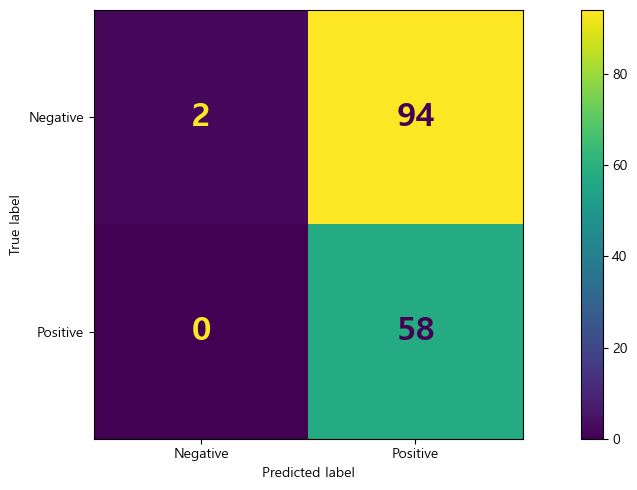


[학습곡선]


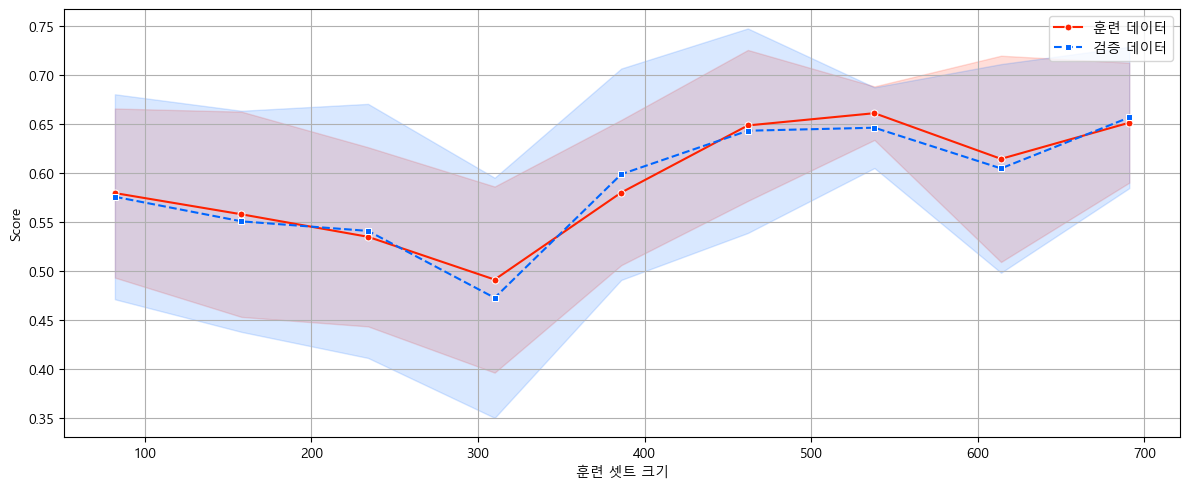

In [13]:
my_classification_result(estimator, x_train, y_train, x_test, y_test)

### [5] 모듈화 기능 확인

[교차검증 TOP5]
+-----+------------+----------------+-----------------+--------+---------+-------------------+
|     |   max_iter | loss           | learning_rate   |   eta0 |   alpha |   mean_test_score |
|-----+------------+----------------+-----------------+--------+---------+-------------------|
| 208 |       1000 | hinge          | adaptive        |    0.5 |     0.1 |          0.731307 |
| 305 |       3000 | hinge          | adaptive        |    0.5 |     0.1 |          0.731307 |
| 293 |       4000 | modified_huber | adaptive        |    0.5 |     0.1 |          0.728055 |
| 427 |       1000 | modified_huber | adaptive        |    0.5 |     0.1 |          0.728055 |
| 287 |       1000 | hinge          | adaptive        |    0.1 |     0.1 |          0.679302 |
+-----+------------+----------------+-----------------+--------+---------+-------------------+

[Best Params]
{'max_iter': 1000, 'loss': 'hinge', 'learning_rate': 'adaptive', 'eta0': 0.5, 'alpha': 0.1}

[분류분석 성능평가]
+------------

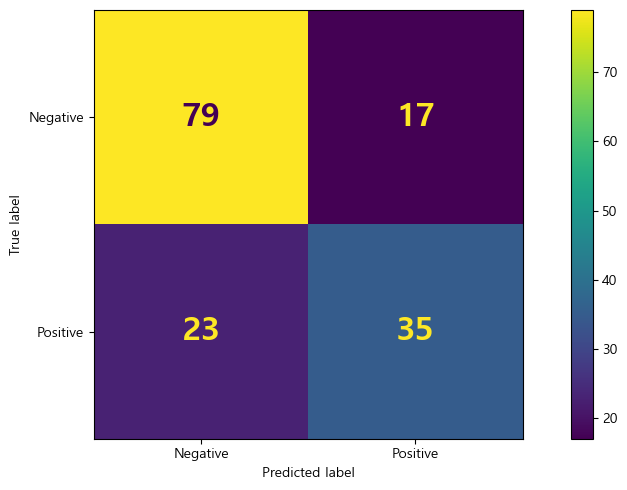


[학습곡선]


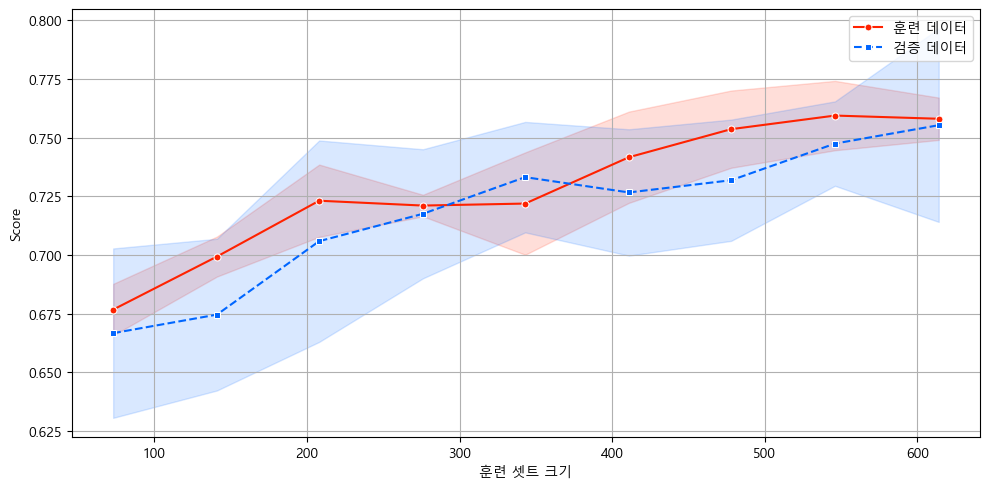

SGDClassifier(alpha=0.1, early_stopping=True, eta0=0.5,
              learning_rate='adaptive', n_jobs=-1, random_state=1234)

In [14]:
my_sgd_classification(x_train,y_train,x_test,y_test)

### [4] 모든 모형에 대한 성능 비교

In [15]:
my_classification(x_train, y_train, x_test, y_test)

<class 'daal4py.sklearn.linear_model.logistic_path.LogisticRegression'>는 early_stopping를 허용하지 않음
<class 'sklearnex.neighbors.knn_classification.KNeighborsClassifier'>는 random_state를 허용하지 않음
<class 'sklearnex.neighbors.knn_classification.KNeighborsClassifier'>는 early_stopping를 허용하지 않음
<class 'sklearnex.svm.svc.SVC'>는 early_stopping를 허용하지 않음
<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
<class 'sklearn.naive_bayes.GaussianNB'>는 random_state를 허용하지 않음
<class 'sklearn.naive_bayes.GaussianNB'>는 early_stopping를 허용하지 않음
<class 'sklearn.tree._classes.DecisionTreeClassifier'>는 n_jobs를 허용하지 않음
<class 'sklearn.tree._classes.DecisionTreeClassifier'>는 early_stopping를 허용하지 않음
+------------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------+
|                        |   의사결정계수(Pseudo R2) |   정확도(Accuracy) |   정밀도(Precision) |   재현율(Recall) |   위양성율(Fallout) |   특이성(TNR) |   F1 S

{'SGDClassifier': SGDClassifier(early_stopping=True, n_jobs=-1, random_state=1234),
 'GaussianNB': GaussianNB(),
 'LogisticRegression': LogisticRegression(C=0.001, max_iter=1000, n_jobs=1, random_state=1234),
 'DecisionTreeClassifier': DecisionTreeClassifier(ccp_alpha=0.006934449410398218, random_state=1234),
 'KNeighborsClassifier': KNeighborsClassifier(metric='manhattan', n_jobs=-1, weights='distance'),
 'SVC': SVC(C=10, degree=2, kernel='poly', n_jobs=-1, random_state=1234)}

## #03. 다항분류 - WINE 데이터 셋

### [1] 데이터 가져오기

In [19]:
origin = my_read_excel('C:/Users/Jihwan/Desktop/01Class/E.추론통계,머신러닝/E.InferentialStatistics/수업자료/wine.xlsx',categories=['class'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   alcohol                       178 non-null    float64 
 1   malic_acid                    178 non-null    float64 
 2   ash                           178 non-null    float64 
 3   alcalinity_of_ash             178 non-null    float64 
 4   magnesium                     178 non-null    int64   
 5   total_phenols                 178 non-null    float64 
 6   flavanoids                    178 non-null    float64 
 7   nonflavanoid_phenols          178 non-null    float64 
 8   proanthocyanins               178 non-null    float64 
 9   color_intensity               178 non-null    float64 
 10  hue                           178 non-null    float64 
 11  od280/od315_of_diluted_wines  178 non-null    float64 
 12  proline                       178 non-null    int6

### [2] 데이터 전처리

1. 종속변수 타입 변환
2. 훈련/검증 데이터 분할 + 데이터 스케일링

In [22]:
origin['class'] = origin['class'].astype('int')

In [23]:
x_train, x_test, y_train, y_test = my_train_test_split(origin, 'class', random_state=123, scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((142, 13), (36, 13), (142,), (36,))

### [3] SGD 분류 모델 구현

[교차검증 TOP5]
+-----+------------+----------------+-----------------+--------+---------+-------------------+
|     |   max_iter | loss           | learning_rate   |   eta0 |   alpha |   mean_test_score |
|-----+------------+----------------+-----------------+--------+---------+-------------------|
| 265 |       2000 | modified_huber | adaptive        |    0.1 |  0.0001 |          0.992857 |
|  54 |       3000 | modified_huber | constant        |    0.1 |  0.0001 |          0.992857 |
| 157 |       3000 | hinge          | optimal         |    0.1 |     0.1 |          0.992857 |
| 228 |       5000 | hinge          | optimal         |   0.01 |     0.1 |          0.992857 |
| 264 |       5000 | modified_huber | constant        |    0.1 |  0.0001 |          0.992857 |
+-----+------------+----------------+-----------------+--------+---------+-------------------+

[Best Params]
{'max_iter': 3000, 'loss': 'modified_huber', 'learning_rate': 'constant', 'eta0': 0.1, 'alpha': 0.0001}

[분류분석 성능평가]
+

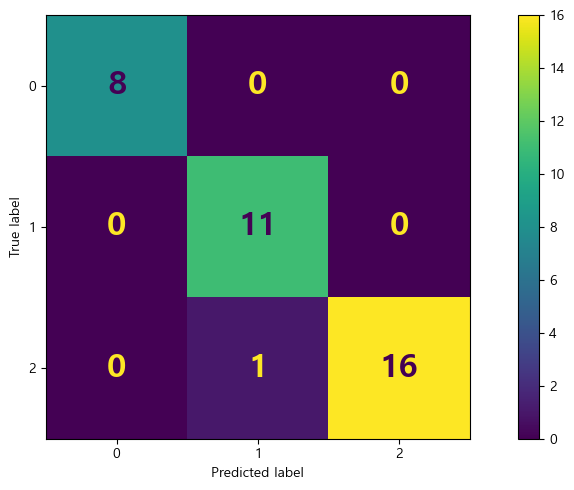


[Roc Curve]


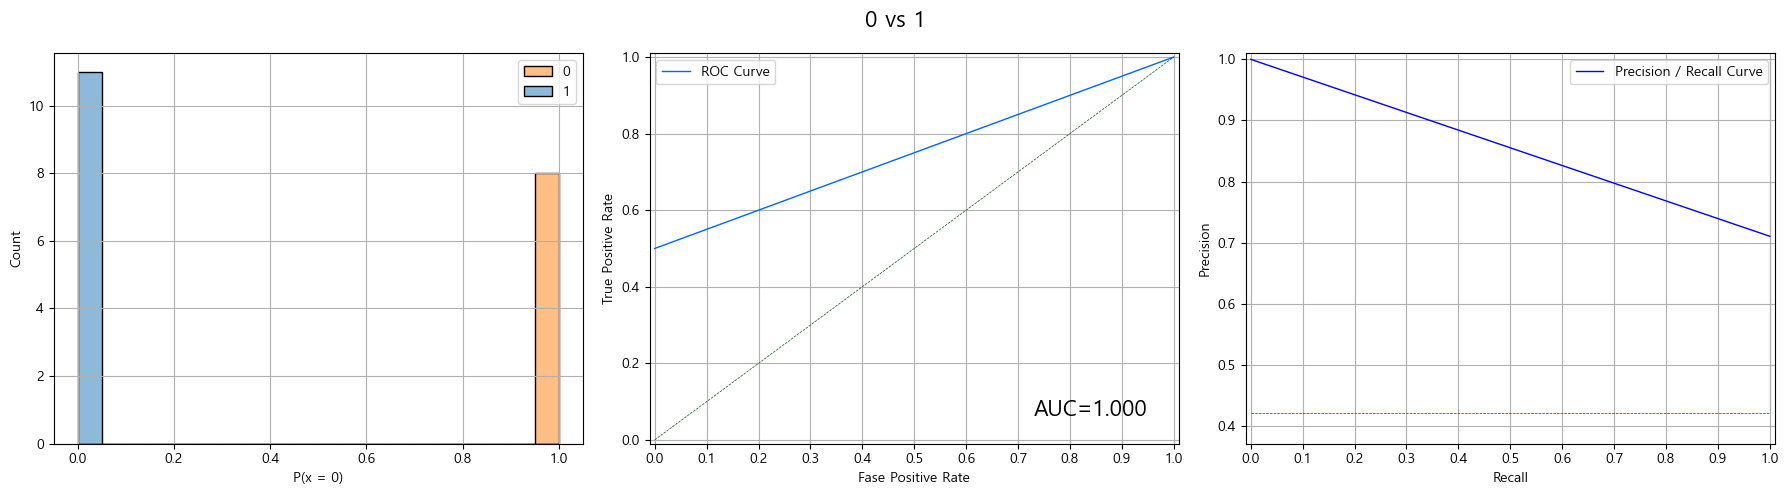

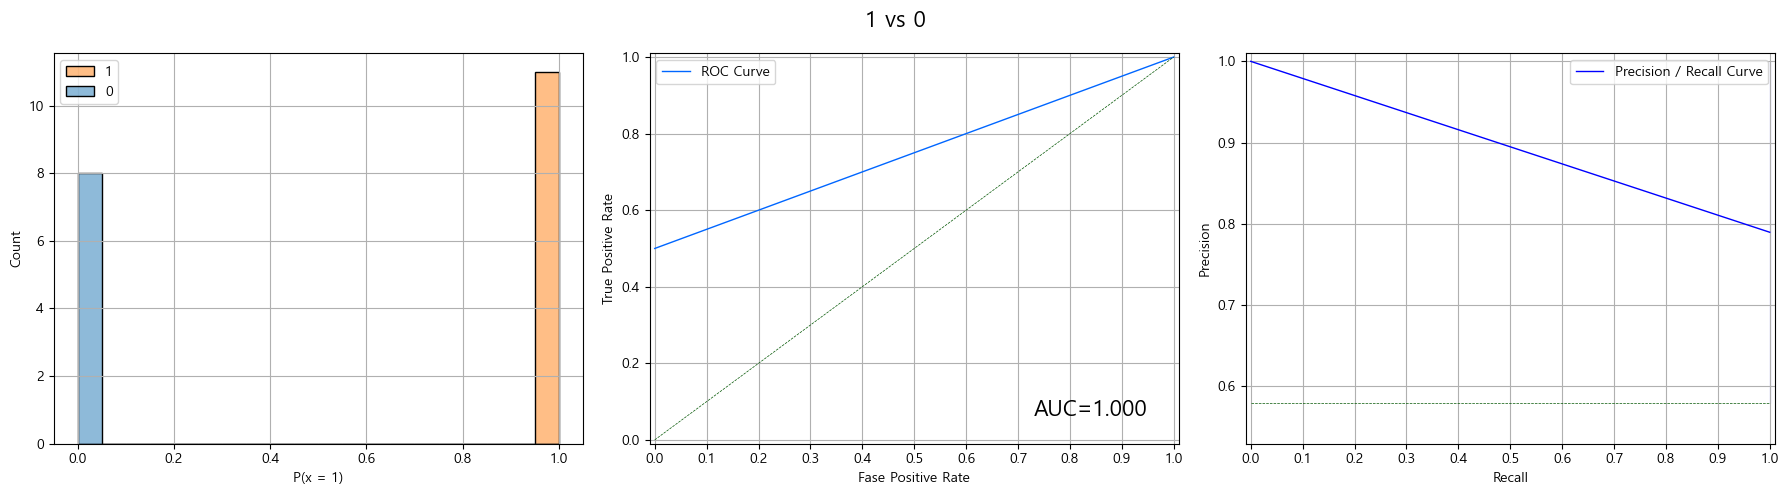

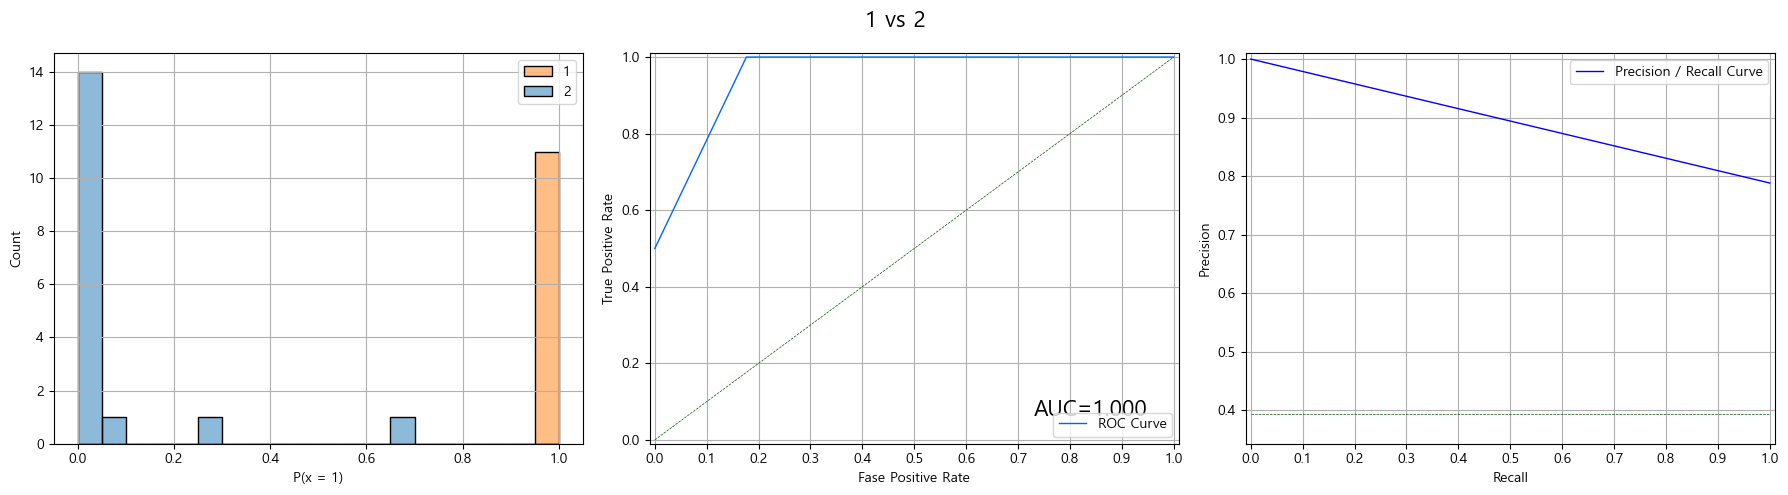

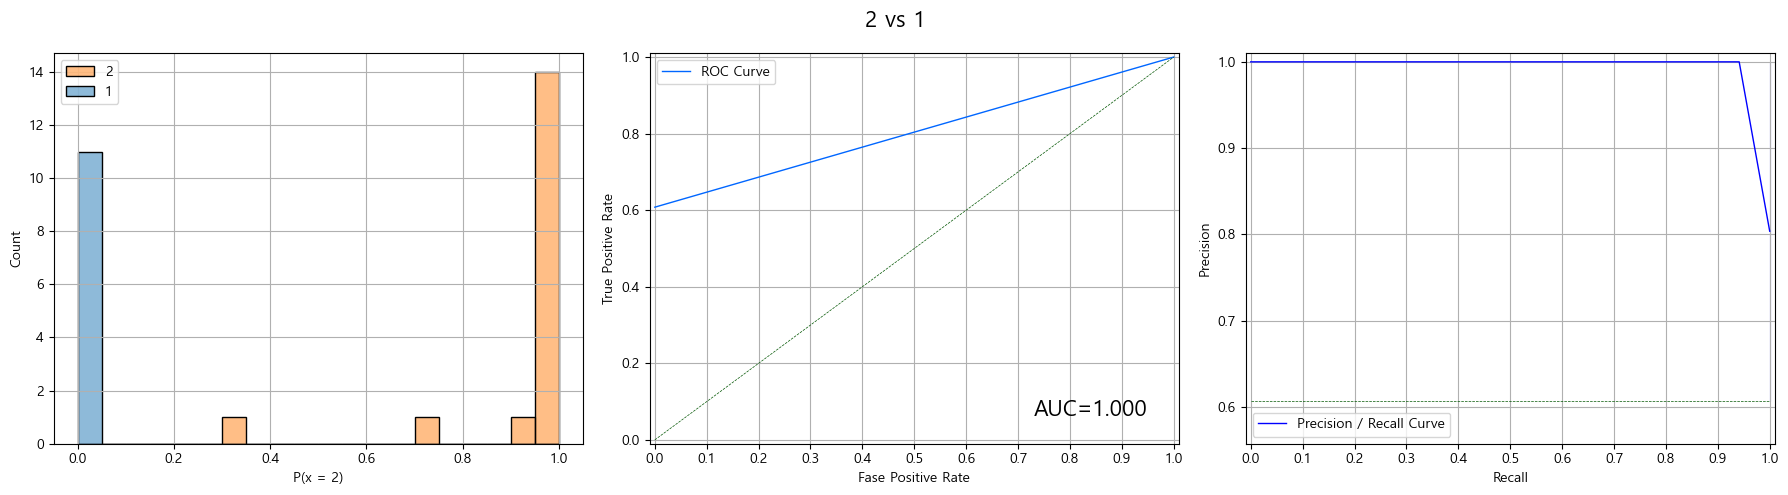

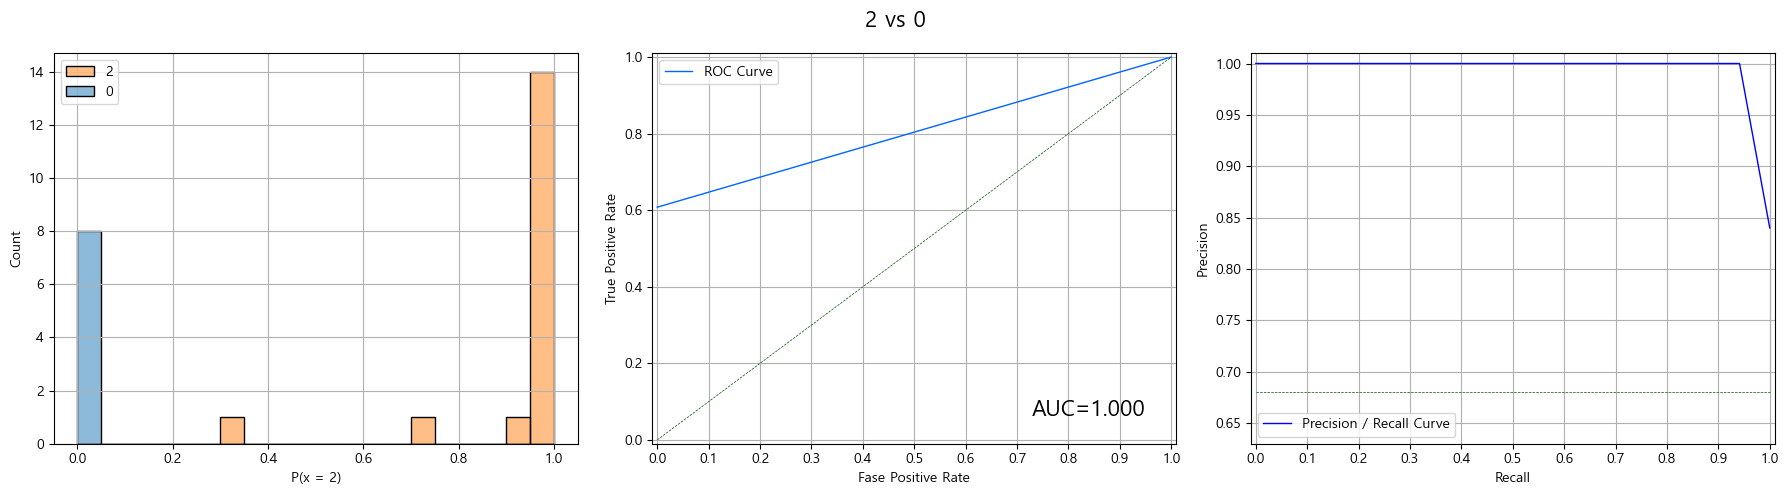

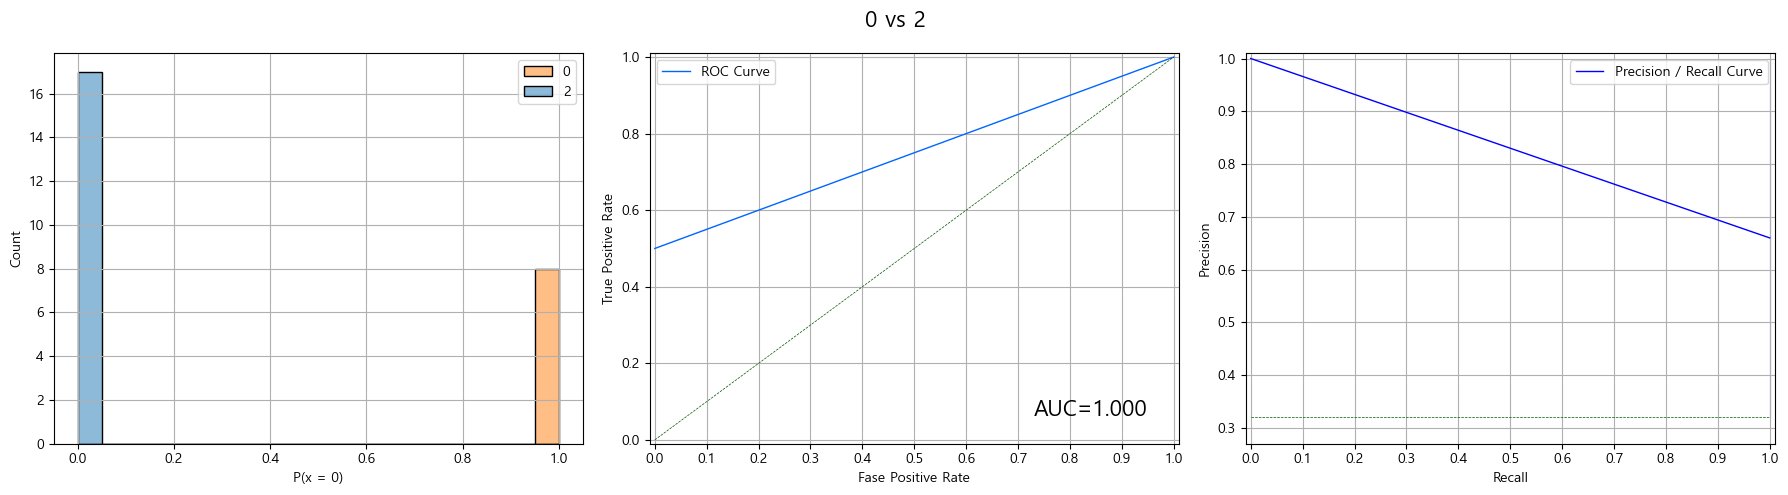

mean roc auc ovo: 1.0000


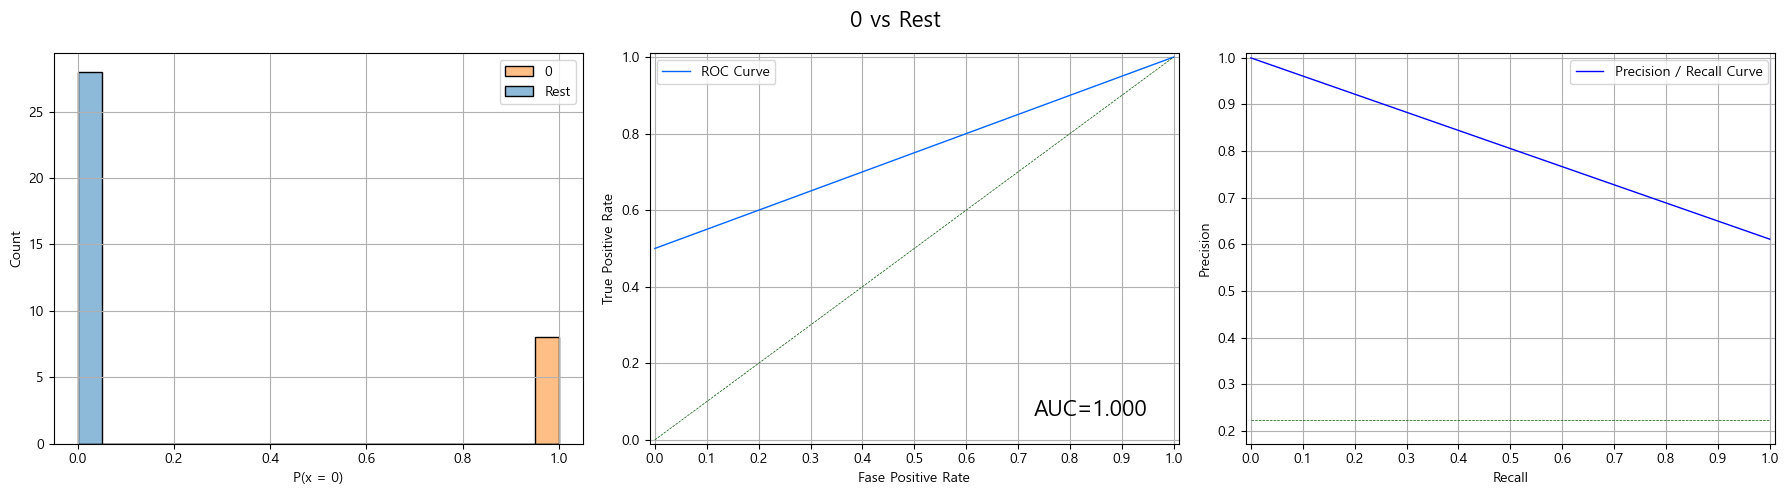

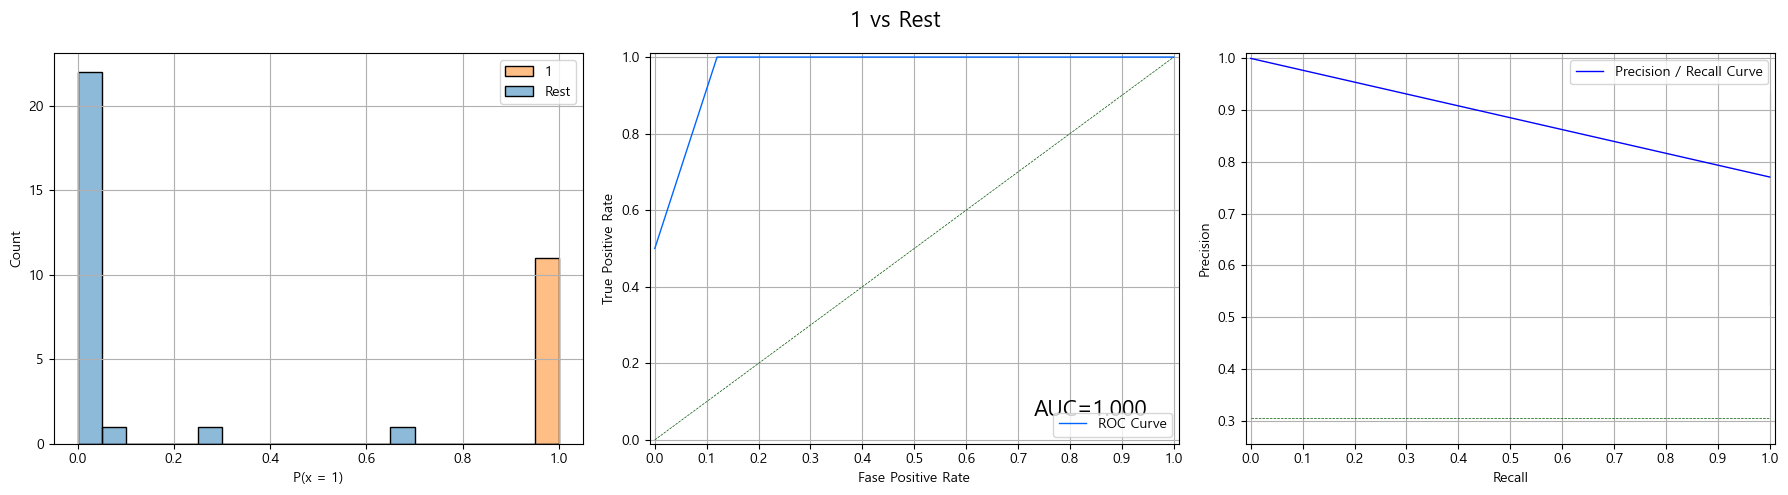

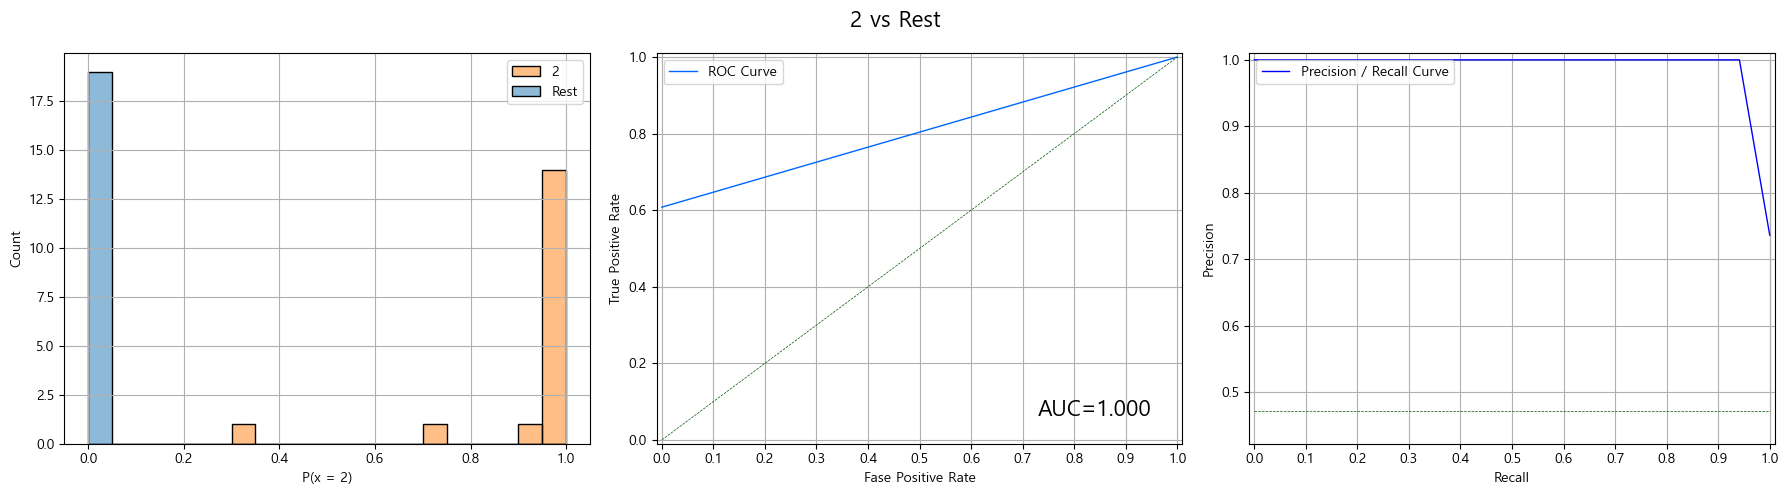

mean roc auc ovo: 1.0000

[학습곡선]


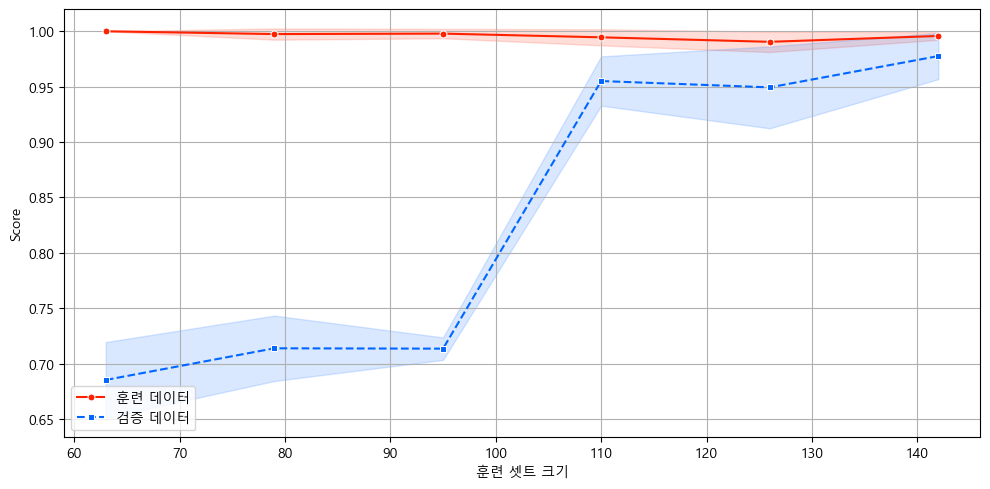

SGDClassifier(early_stopping=True, eta0=0.1, learning_rate='constant',
              loss='modified_huber', max_iter=3000, n_jobs=-1,
              random_state=1234)

In [24]:
my_sgd_classification(x_train, y_train, x_test, y_test)

### [4] 모든 모형에 대한 성능 비교

In [25]:
my_classification(x_train, y_train, x_test, y_test)

<class 'daal4py.sklearn.linear_model.logistic_path.LogisticRegression'>는 early_stopping를 허용하지 않음
<class 'sklearnex.neighbors.knn_classification.KNeighborsClassifier'>는 random_state를 허용하지 않음
<class 'sklearnex.neighbors.knn_classification.KNeighborsClassifier'>는 early_stopping를 허용하지 않음
<class 'sklearnex.svm.svc.SVC'>는 early_stopping를 허용하지 않음
<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
<class 'sklearn.naive_bayes.GaussianNB'>는 random_state를 허용하지 않음
<class 'sklearn.naive_bayes.GaussianNB'>는 early_stopping를 허용하지 않음
<class 'sklearn.tree._classes.DecisionTreeClassifier'>는 n_jobs를 허용하지 않음
<class 'sklearn.tree._classes.DecisionTreeClassifier'>는 early_stopping를 허용하지 않음
+------------------------+--------------------+---------------------+------------------+------------+------------+------------+
|                        |   정확도(Accuracy) |   정밀도(Precision) |   재현율(Recall) |   F1 Score |   AUC(ovo) |   AUC(ovr) |
|------------------------+--------------------+---------------------+--

{'GaussianNB': GaussianNB(),
 'SGDClassifier': SGDClassifier(early_stopping=True, n_jobs=-1, random_state=1234),
 'DecisionTreeClassifier': DecisionTreeClassifier(ccp_alpha=0.011267605633802814, random_state=1234),
 'LogisticRegression': LogisticRegression(C=1, max_iter=1000, n_jobs=1, random_state=1234),
 'SVC': SVC(C=0.1, degree=2, kernel='sigmoid', n_jobs=-1, random_state=1234),
 'KNeighborsClassifier': KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=7)}